# Simulations on COVID-19 DATA

### Importing necessary libraries.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

### Importing the data.

In [3]:
data_covid = pd.read_csv('https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv')

### Taking the necessary rows & columns from the data and resetting the index.

In [45]:
cols_to_keep = ['iso_code', 'location', 'date', 'total_cases', 'new_cases', 'total_deaths', 'new_deaths', 'reproduction_rate', 'population', 'cardiovasc_death_rate']
cols_to_delete = data_covid.columns.difference(cols_to_keep)
usa_data = data_covid[data_covid["location"] == "United States"]
usa_data.drop(cols_to_delete, axis = 1, inplace=True)
usa_data.reset_index(drop=True, inplace=True)
usa_data = usa_data.iloc[21:, :]
usa_data.dropna(inplace=True)
usa_data.reset_index(drop=True, inplace=True)
usa_data = usa_data.iloc[3:, :]
usa_data.reset_index(drop=True, inplace=True)

/var/folders/33/6t1xnkrd2tbb5n7q452xfbgc0000gn/T/ipykernel_27202/1532021473.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usa_data.drop(cols_to_delete, axis = 1, inplace=True)


### Changing the data type of the "Date" column & assigning it to index.

In [46]:
usa_data.date = pd.to_datetime(usa_data['date'])
usa_data.set_index(usa_data['date'],inplace=True)

### As the data had been updated weekly, there are 0-rows between every 7th row, so those rows need to be deleted for simplicity and ease of calculations

In [47]:
usa_data=usa_data[usa_data['new_cases']!=0]

### The dataset does not contain data for active cases for respective weeks, so using the information that the infection period for COVID-19 was 2 weeks, we can approximate the active cases by taking the difference between each 2 weeks, assuming that for the first 2 weeks be did not have recovered people.

In [48]:
released = usa_data['total_cases'].shift(2).fillna(0)
usa_data['active_cases'] = usa_data['total_cases'] - released

### The plot shows that our assumption was close to reality, as our experience showed that the active cases in real life had similar trend. (i.e it had several local maximums, after reaching a global maximum it started to decrease)

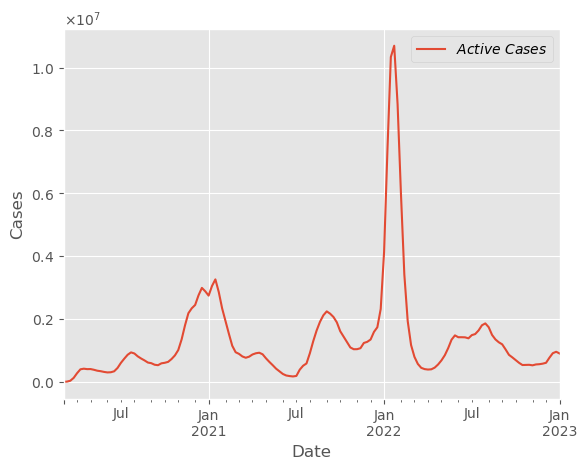

In [49]:
usa_data['active_cases'].plot(kind='line', label='$Active\ Cases$')
plt.legend()
plt.ticklabel_format(axis='y', useMathText=True)
plt.xlabel('Date')
plt.ylabel('Cases')
plt.style.use('ggplot')

### We can use the same difference in the upper part as a "Recovered" column in our dataset.

In [50]:
usa_data['released'] = released

### As the Susceptible part of the population is that part that can potentially be infected, we can approximate their number by subtracting from the total population the number of total cases and the number of released people. (Assuming that one person can be infected just once)

In [51]:
usa_data['susceptibles'] = usa_data['population'] - usa_data['total_cases'] - usa_data['released']

### Plotting the results.

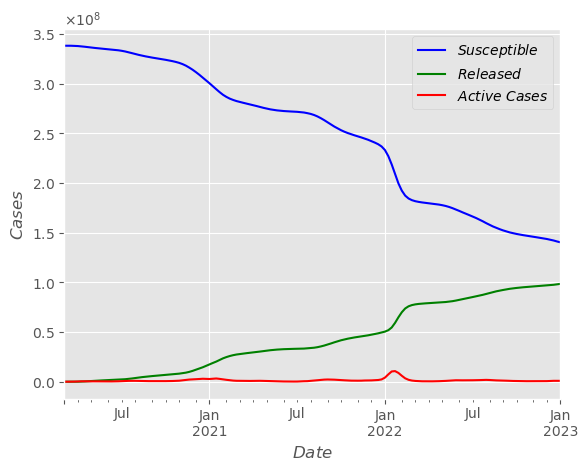

In [52]:
usa_data['susceptibles'].plot(kind='line', color='blue', label='$Susceptible$')
usa_data['released'].plot(kind='line', color='green', label='$Released$')
usa_data['active_cases'].plot(kind='line', color='red', label='$Active\ Cases$')
plt.ticklabel_format(axis='y', useMathText=True)
plt.xlabel('$Date$')
plt.ylabel('$Cases$')
plt.legend()

## Calucaltion the constants(Infection and Recovery rates) for the model.

### Defining constants and range for Infection and Recovery rates.

In [53]:
N = 338289586 #Population	
I0 = 464 # Initial number of infected people
R0 = 0 # Initial number of recovered people
S0 = N - I0 - R0 # Initial number of susceptible people
err_arr = []
beta_arr = np.linspace(0.1, 1, 500) # Range for Infection rate
gamma_arr = np.linspace(0.1, 1, 500) # Range for Recovery rate

# Approximations on USA Data

### Splitting the Data Frame

In [54]:
i_half = np.array_split(usa_data['active_cases'], 2)[0]
s_half = np.array_split(usa_data['susceptibles'], 2)[0]
r_half = np.array_split(usa_data['released'], 2)[0]

/Users/aram/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


### Defining a Function for Calculating Derivatives.

In [55]:
def deriv(y, t, beta, gamma):
    S = y[0]
    I = y[1]
    dSdt = -beta * S[t] * I[t]
    dIdt = beta * S[t] * I[t] - gamma * I[t]
    dRdt = gamma * I[t]
    return dSdt, dIdt, dRdt

### Approximating Infection and Recovery rates by minimizing an Error function$\left(\sum_{t=0}^{n}(y(t) - y_t)^2\right)$ where $y(t)$ is the real world data and $y_t$ is Euler's approximation on half the data.

In [56]:
for n in beta_arr:
    for j in gamma_arr:
        beta = n / N
        gamma = j
        
        h = 1
        t = np.arange(0, 73 + h, h)

        s = np.zeros(len(t))
        s[0] = S0

        i = np.zeros(len(t))
        i[0] = I0

        r = np.zeros(len(t))
        r[0] = R0

        y = [s, i, r]

        for i in range(0, len(t) - 1):
            der = deriv(y, i, beta, gamma)
            for k in range(0, 3):
                y[k][i + 1] = y[k][i] + h * der[k]
        err = np.sum((i_half - np.asarray(y[1]))**2) + np.sum((r_half - np.asarray(y[2]))**2) + np.sum((s_half - np.asarray(y[0]))**2)
        if not np.isnan(err):
            err_arr.append([beta * N, gamma, err])
    
err_arr = sorted(err_arr, key=lambda x: x[2])

### Approximating the SIR using Euler's method with optimized Infection and recovery rates on half the data.

In [57]:
beta = err_arr[0][0] / N
gamma = err_arr[0][1]

h = 1
t = np.arange(0, 147 + h, h)

s = np.zeros(len(t))
s[0] = S0

i = np.zeros(len(t))
i[0] = I0

r = np.zeros(len(t))
r[0] = R0

y = [s, i, r]

for i in range(0, len(t) - 1):
    der = deriv(y, i, beta, gamma)
    for k in range(0, 3):
        y[k][i + 1] = y[k][i] + h * der[k]

### Adding values to Data Frame

In [58]:
usa_data['approx_infected'] = y[1]
usa_data['approx_susceptible'] = y[0]
usa_data['approx_released'] = y[2]

### Plotting the results

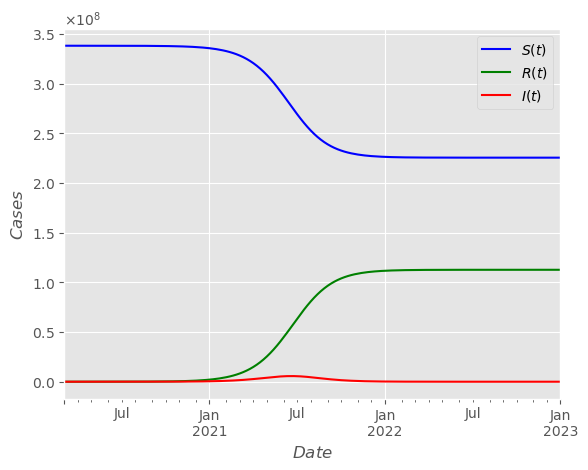

In [59]:
usa_data['approx_susceptible'].plot(kind='line', color='blue', label='$S(t)$')
usa_data['approx_released'].plot(kind='line', color='green', label='$R(t)$')
usa_data['approx_infected'].plot(kind='line', color='red', label='$I(t)$')
plt.ticklabel_format(axis='y', useMathText=True)
plt.xlabel('$Date$')
plt.ylabel('$Cases$')
plt.legend()

### Comparing results

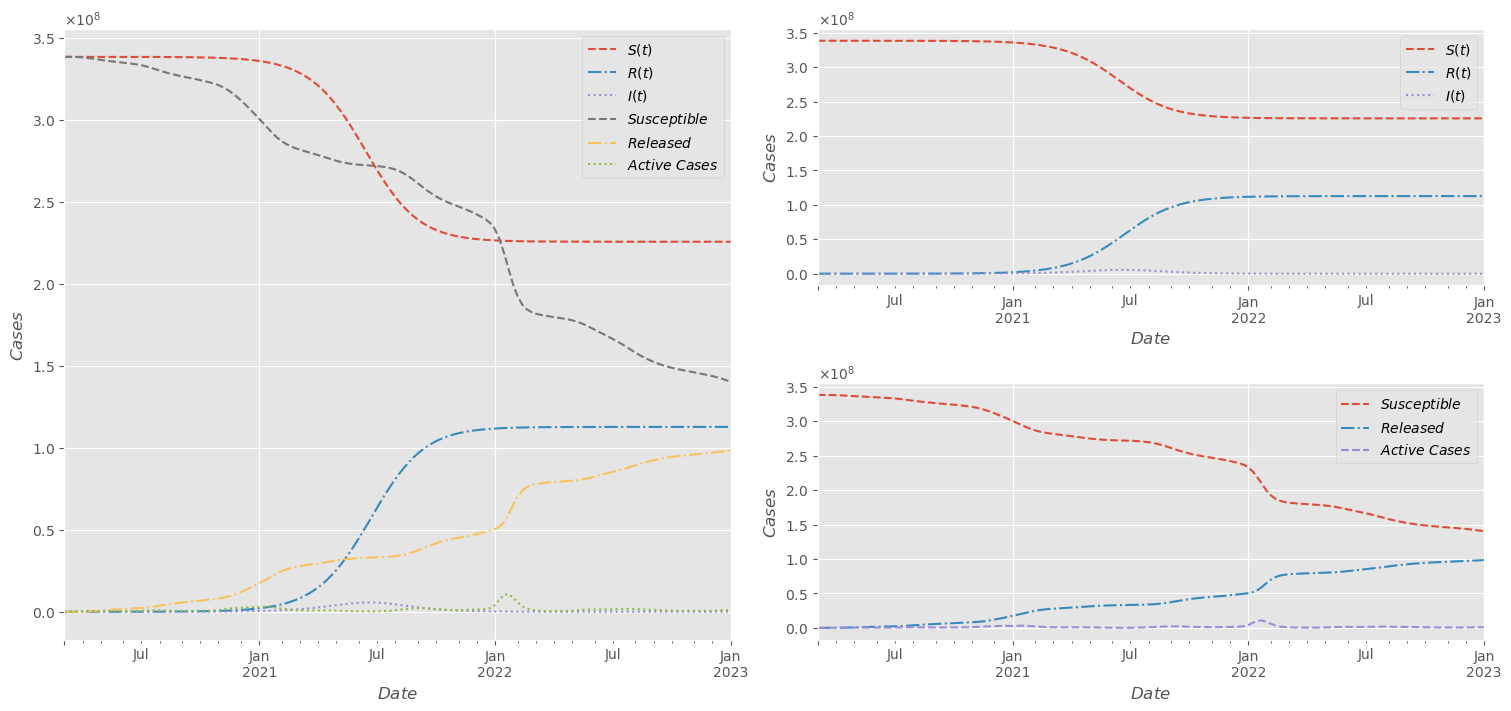

In [60]:
fig = plt.figure(layout='constrained', figsize=(15, 7))
axes = fig.subplot_mosaic([[0,1],[0,2]])
usa_data['approx_susceptible'].plot(kind='line', linestyle='--', label='$S(t)$', ax=axes[1])
usa_data['approx_released'].plot(kind='line', linestyle='-.', label='$R(t)$', ax=axes[1])
usa_data['approx_infected'].plot(kind='line', linestyle=':', label='$I(t)$', ax=axes[1])

usa_data['susceptibles'].plot(kind='line', linestyle='--', label='$Susceptible$', ax=axes[2])
usa_data['released'].plot(kind='line', linestyle='-.', label='$Released$', ax=axes[2])
usa_data['active_cases'].plot(kind='line', linestyle='--', label='$Active\ Cases$', ax=axes[2])

usa_data['approx_susceptible'].plot(kind='line', linestyle='--', label='$S(t)$', ax=axes[0])
usa_data['approx_released'].plot(kind='line', linestyle='-.', label='$R(t)$', ax=axes[0])
usa_data['approx_infected'].plot(kind='line', linestyle=':', label='$I(t)$', ax=axes[0])
usa_data['susceptibles'].plot(kind='line', linestyle='--', label='$Susceptible$', ax=axes[0])
usa_data['released'].plot(kind='line', linestyle='-.', label='$Released$', ax=axes[0])
usa_data['active_cases'].plot(kind='line', linestyle=':', label='$Active\ Cases$', ax=axes[0])

for i in range(3):
    axes[i].ticklabel_format(axis='y', useMathText=True)
    axes[i].set_xlabel('$Date$')
    axes[i].set_ylabel('$Cases$')
    axes[i].legend()

# Doing the same on Armenia\'s Data.

### Taking the necessary rows & columns from the data and resetting the index. Cleaning the data and adding the necessary information.

In [61]:
cols_to_keep = ['iso_code', 'location', 'date', 'total_cases', 'new_cases', 'total_deaths', 'new_deaths', 'reproduction_rate', 'population', 'cardiovasc_death_rate']
cols_to_delete = data_covid.columns.difference(cols_to_keep)
arm_data = data_covid[data_covid["location"] == "Armenia"]
arm_data.drop(cols_to_delete, axis = 1, inplace=True)
arm_data.reset_index(drop=True, inplace=True)
arm_data = arm_data.iloc[21:, :]
arm_data.dropna(inplace=True)
arm_data.reset_index(drop=True, inplace=True)
arm_data = arm_data.iloc[3:, :]
arm_data.reset_index(drop=True, inplace=True)

arm_data.date = pd.to_datetime(arm_data['date'])
arm_data.set_index(arm_data['date'],inplace=True)

arm_data=arm_data[arm_data['new_cases']!=0]

released = arm_data['total_cases'].shift(2).fillna(0)
arm_data['active_cases'] = arm_data['total_cases'] - released

arm_data['released'] = released

arm_data['susceptibles'] = arm_data['population'] - arm_data['total_cases'] - arm_data['released']

/var/folders/33/6t1xnkrd2tbb5n7q452xfbgc0000gn/T/ipykernel_27202/769534647.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  arm_data.drop(cols_to_delete, axis = 1, inplace=True)


### Defining constants and range for Infection and Recovery rates.

In [62]:
N = 2780472.0 #Population	
I0 = 424 # Initial number of infected people
R0 = 0 # Initial number of recovered people
S0 = N - I0 - R0 # Initial number of susceptible people
err_arr = []
beta_arr = np.linspace(0.1, 1, 100) # Range for Infection rate
gamma_arr = np.linspace(0.1, 1, 100) # Range for Recovery rate

### Splitting the Data Frame.

In [63]:
i_half = np.array_split(arm_data['active_cases'], 2)[0]
s_half = np.array_split(arm_data['susceptibles'], 2)[0]
r_half = np.array_split(arm_data['released'], 2)[0]

/Users/aram/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


### Defining a Function for Calculating Derivatives.

In [64]:
def deriv(y, t, beta, gamma):
    S = y[0]
    I = y[1]
    dSdt = -beta * S[t] * I[t]
    dIdt = beta * S[t] * I[t] - gamma * I[t]
    dRdt = gamma * I[t]
    return dSdt, dIdt, dRdt

### Approximating Infection and Recovery rates by minimizing an Error function$\left(\sum_{0}^{n}(y(t) - y_t)^2\right)$ where $y(t)$ is the real world data and $y_t$ is Euler's approximation on half the data.

In [65]:
for n in beta_arr:
    for j in gamma_arr:
        beta = n / N
        gamma = j
        
        h = 1
        t = np.arange(0, 71 + h, h)

        s = np.zeros(len(t))
        s[0] = S0

        i = np.zeros(len(t))
        i[0] = I0

        r = np.zeros(len(t))
        r[0] = R0

        y = [s, i, r]

        for i in range(0, len(t) - 1):
            der = deriv(y, i, beta, gamma)
            for k in range(0, 3):
                y[k][i + 1] = y[k][i] + h * der[k]
        err = np.sum((i_half - np.asarray(y[1]))**2) + np.sum((r_half - np.asarray(y[2]))**2) + np.sum((s_half - np.asarray(y[0]))**2)
        if not np.isnan(err):
            err_arr.append([beta * N, gamma, err])
    
err_arr = sorted(err_arr, key=lambda x: x[2])

### Approximating the SIR using Euler's method with optimized Infection and recovery rates on half the data.### Defining constants and range for Infection and Recovery rates.

In [66]:
beta = err_arr[0][0] / N
gamma = err_arr[0][1]

h = 1
t = np.arange(0, 143 + h, h)

s = np.zeros(len(t))
s[0] = S0

i = np.zeros(len(t))
i[0] = I0

r = np.zeros(len(t))
r[0] = R0

y = [s, i, r]

for i in range(0, len(t) - 1):
    der = deriv(y, i, beta, gamma)
    for k in range(0, 3):
        y[k][i + 1] = y[k][i] + h * der[k]

### Adding values to Data Frame

In [67]:
arm_data['approx_infected'] = y[1]
arm_data['approx_susceptible'] = y[0]
arm_data['approx_released'] = y[2]

### Plotting the Results.

Text(0.5, 1.0, 'Real-World Data')

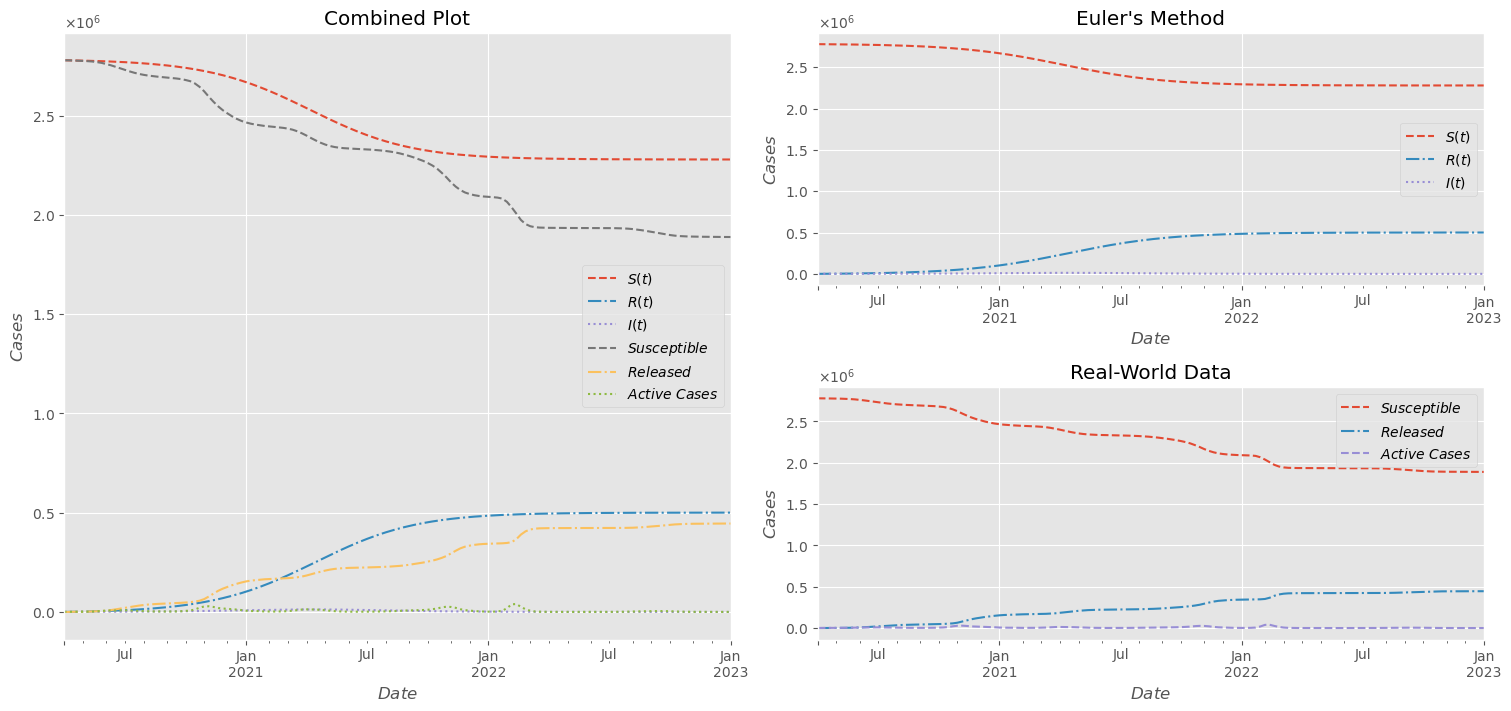

In [68]:
fig = plt.figure(layout='constrained', figsize=(15, 7))
axes = fig.subplot_mosaic([[0,1],[0,2]])
arm_data['approx_susceptible'].plot(kind='line', linestyle='--', label='$S(t)$', ax=axes[1])
arm_data['approx_released'].plot(kind='line', linestyle='-.', label='$R(t)$', ax=axes[1])
arm_data['approx_infected'].plot(kind='line', linestyle=':', label='$I(t)$', ax=axes[1])

arm_data['susceptibles'].plot(kind='line', linestyle='--', label='$Susceptible$', ax=axes[2])
arm_data['released'].plot(kind='line', linestyle='-.', label='$Released$', ax=axes[2])
arm_data['active_cases'].plot(kind='line', linestyle='--', label='$Active\ Cases$', ax=axes[2])

arm_data['approx_susceptible'].plot(kind='line', linestyle='--', label='$S(t)$', ax=axes[0])
arm_data['approx_released'].plot(kind='line', linestyle='-.', label='$R(t)$', ax=axes[0])
arm_data['approx_infected'].plot(kind='line', linestyle=':', label='$I(t)$', ax=axes[0])
arm_data['susceptibles'].plot(kind='line', linestyle='--', label='$Susceptible$', ax=axes[0])
arm_data['released'].plot(kind='line', linestyle='-.', label='$Released$', ax=axes[0])
arm_data['active_cases'].plot(kind='line', linestyle=':', label='$Active\ Cases$', ax=axes[0])

for i in range(3):
    axes[i].ticklabel_format(axis='y', useMathText=True)
    axes[i].set_xlabel('$Date$')
    axes[i].set_ylabel('$Cases$')
    axes[i].legend()
axes[0].set_title('Combined Plot')
axes[1].set_title('Euler\'s Method')
axes[2].set_title('Real-World Data')